# Imports

In [61]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy import stats
plt.rc('font', size=16) 

# Utility functions

In [2]:
def plot_gaussian(ax, mean, cov, color='red', size=3):
    # draws 3 different covariances representing 1, 2 and 3 standard deviations
    # width and height are times by 2 since sqrt of the eigenval only measures half the distance
    eig_w, eig_v = np.linalg.eig(cov)    
    for i in range(size):
        ell = Ellipse(xy=[mean[0], mean[1]], 
                      width=np.sqrt(eig_w[0]) * 2 * (i + 1), 
                      height=np.sqrt(eig_w[1]) * 2 * (i + 1), 
                      angle=np.rad2deg(np.arccos(eig_v[0, 0])), 
                      edgecolor=color, lw=2, facecolor='none')
        ax.add_artist(ell)

# $\star$ Question 1:

Run the Sklearn implementations of k-means and expectation maximization on the dataset *gaussianplus.npz*.


Plot the estimated assignments and the estimated
parameters of the two Gaussians. 

Describe how the fitting by expectation maximization outperforms the one with k-means.

Try with varying, also
very bad initializations. How stable are the results?

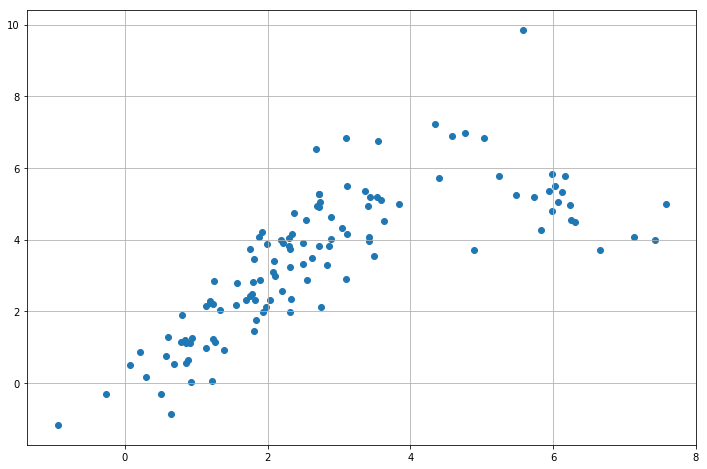

In [3]:
# Load and visualize the dataset:
data = np.load('../data/gaussianplus.npz')["arr_0"]

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(data[:, 0], data[:, 1])
ax.grid()

## Run K-Means:

Centroids:
[[4.47527286 5.20701391]
 [1.57166965 2.14473835]]


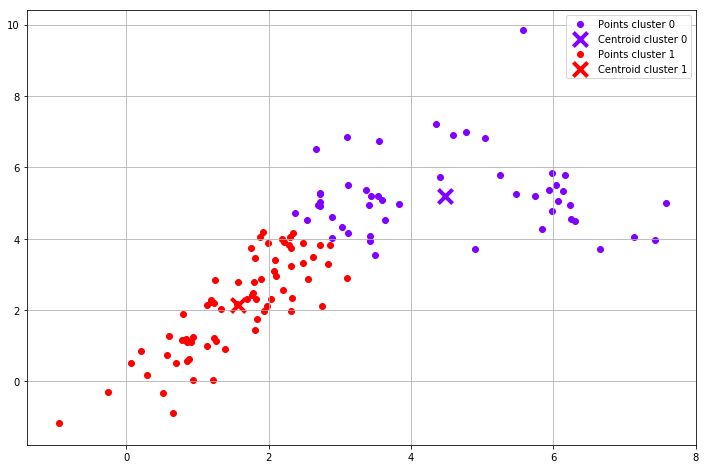

In [48]:
def run_and_plot_k_means(data, init='random', k=2): 
    """
    Runs the K-means algorithm from sklearn on the input data and plots the results. 
    
    Args:
        data: Input data.
        init: Initialization method (see the sklearn documentation).
        k : Number of clusters.
    """
    # Apply the K-Means clustering implementation from sklearn (see documentation for usage instructions).
    # Store the cluster assignments in a variable called 'labels' and the cluster centroids in a 
    # variable called 'centroids':
    kmeans = KMeans(n_clusters=k, init=init, random_state=0, n_init=1)
    kmeans.fit(data)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
    # Print and plot results:
    print("Centroids:\n{}".format(centroids))   
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.grid()
    
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, k)]
    for i, color in enumerate(colors):
        cluster = data[labels==i]
        ax.scatter(cluster[:, 0], cluster[:, 1], color=color, label="Points cluster {}".format(i))
        ax.scatter(centroids[i, 0], centroids[i, 1], color=color, marker="x", s=200, lw=4, label="Centroid cluster {}".format(i))

    ax.legend()
    

# random init 
run_and_plot_k_means(data, init='random')

Centroids:
[[1.38663598 1.75281102]
 [4.04352806 4.92971669]]


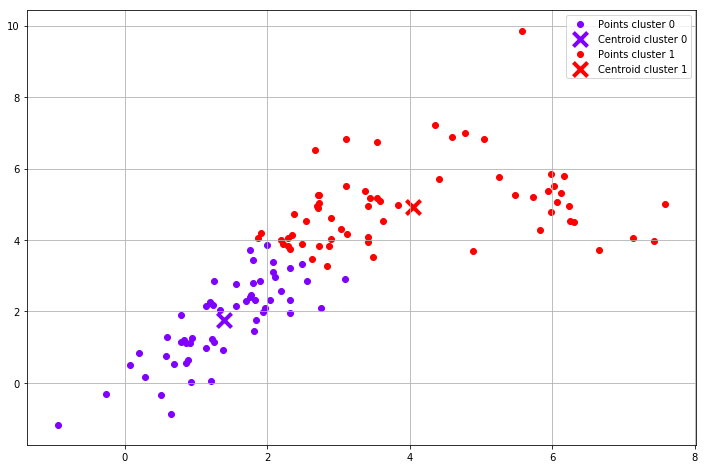

In [5]:
# manual init 
run_and_plot_k_means(data, init=np.array([[16,16], [14,14]]))

## Run EM algorithm:

Means:
[[2.12852679 3.12523607]
 [6.11288948 4.92802653]]
Mixture weights:
[0.83611494 0.16388506]


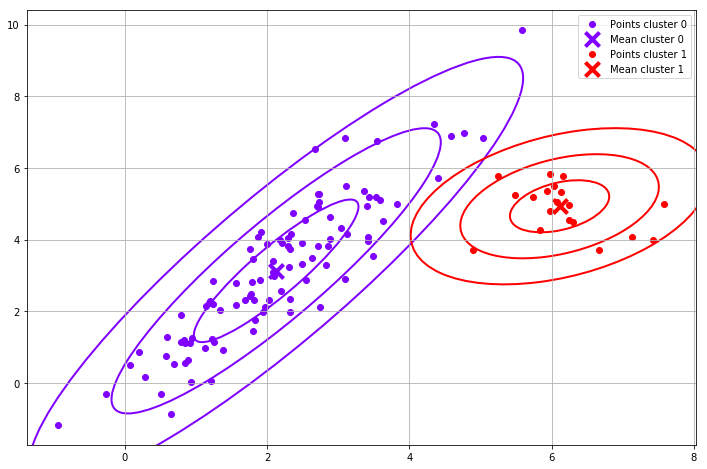

In [9]:
def run_and_plot_em(data, means_init=None, k=2): 
    """
    Runs the EM algorithm from sklearn on the input data and plots the results. 
    
    Args:
        data: Input data.
        means_init: Initial means of the gaussians.
        k: Number of mixture components.
    """
    # Apply the EM-algorithm implementation from sklearn (see documentation for usage instructions).
    # Store the cluster assignments in a variable called 'labels', the estimated means in a variable 'means',
    # the estimated weights in a variable 'weights' and the estimated covariances in a variable 'covariances'.
    em = GaussianMixture(n_components=k, init_params='random', means_init=means_init)
    em.fit(data)
    labels = em.predict(data)
    weights = em.weights_
    means = em.means_
    covariances = em.covariances_
    
    # Print and plot results:
    print("Means:\n{}".format(means))
    print("Mixture weights:\n{}".format(weights))
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.grid()
    
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, k)]
    for i, color in enumerate(colors):
        cluster = data[labels==i]
        ax.scatter(cluster[:, 0], cluster[:, 1], color=color, label="Points cluster {}".format(i))
        plot_gaussian(ax, means[i], covariances[i], color=color, size=3)
        ax.scatter(means[i, 0], means[i, 1], color=color, marker="x", s=200, lw=4, label="Mean cluster {}".format(i))
        
    ax.legend()
    

# random init 
run_and_plot_em(data)

Means:
[[5.57839694 9.85013372]
 [2.75800102 3.36665753]]
Mixture weights:
[0.00833333 0.99166667]


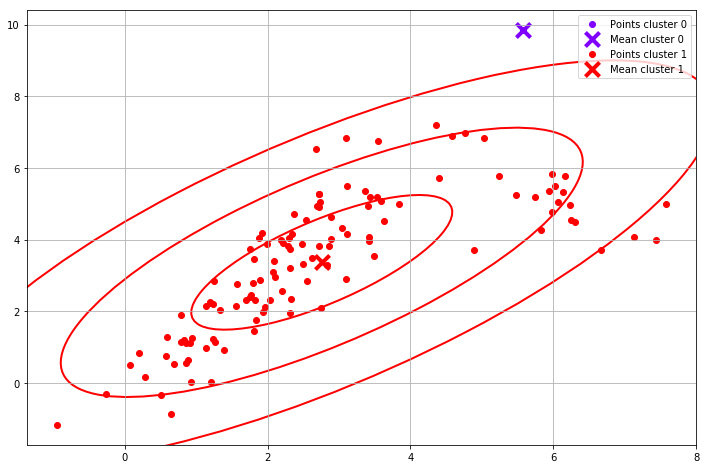

In [16]:
run_and_plot_em(data, means_init=np.array([[16,16], [10,10]]))

# $\star\star\star$  Question 2:

Build your own implementations of k-means and EM to learn in
detail how these important algorithms work.

Compare your implementation with the sklearn
implementation.

## Custom K-means implementation:

In [49]:
class SimpleKMeans:
    def __init__(self, k, mean_init, num_iters=100):
        """Custom k-means implementation.
        
        Args:
            k: Number of clusters.
            mean_init: Initial cluster means as np array of shape (num_clusters, dimensions).
            num_iters: Number of iterations.
        """
        self.centroids = mean_init.astype(np.float)
        self.labels = None
        self.num_iters = num_iters
        self.k = k
        
    def fit(self, data):
        for i in range(self.num_iters):
            # E step:
            # compute assignments based on distances of each data point to the k centroids
            distances = np.array([]).reshape(data.shape[0], 0)
            for k in range(self.k):
                dist = np.sum((data - self.centroids[k,:])**2, axis=1)
                distances = np.c_[distances, dist]
            # distances has shape (N, k)
            self.labels = np.argmin(distances, axis=1)  # shape: (N)
            
            # M step:
            # compute centroids as mean of assigned data points:
            for k in range(0, self.k):
                cluster = data[self.labels == k]
                self.centroids[k,:] = np.mean(cluster, axis=0)

Centroids:
[[4.47527286 5.20701391]
 [1.57166965 2.14473835]]
Centroids:
[[4.47527286 5.20701391]
 [1.57166965 2.14473835]]


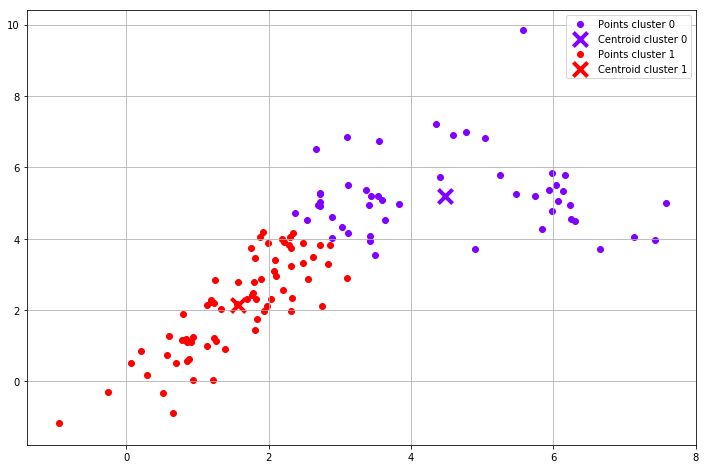

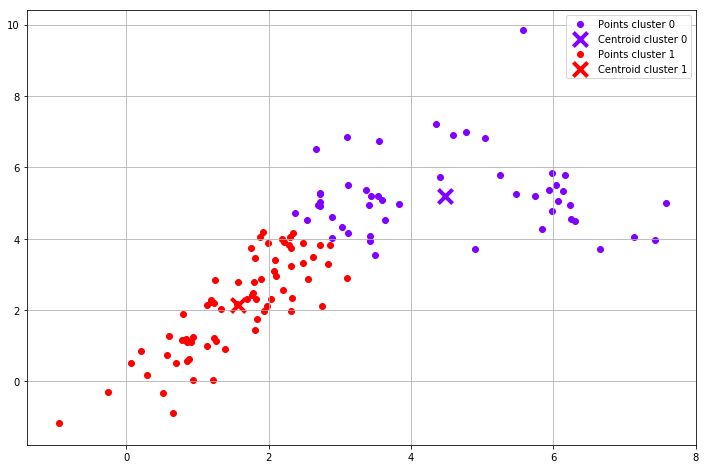

In [54]:
def run_and_plot_simple_k_means(data, init=np.array([[4,4], [10,4]]), k=2, num_iters=10): 
    """Runs the custom K-means implementation on the input data and plots the results. 
    
    Args:
        data: Input data.
        init: Initial cluster centroids.
        k : Number of clusters.
        num_iters : Number of iterations.
    """
    # Apply the custom K-Means clustering implementation.
    # Store the cluster assignments in a variable called 'labels' and the cluster centroids in a 
    # variable called 'centroids':
    kmeans = SimpleKMeans(k=k, mean_init=init, num_iters=num_iters)
    kmeans.fit(data)
    labels = kmeans.labels
    centroids = kmeans.centroids
    
    # Print and plot results:
    print("Centroids:\n{}".format(centroids))   
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.grid()
    
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, k)]
    for i, color in enumerate(colors):
        cluster = data[labels==i]
        ax.scatter(cluster[:, 0], cluster[:, 1], color=color, label="Points cluster {}".format(i))
        ax.scatter(centroids[i, 0], centroids[i, 1], color=color, marker="x", s=200, lw=4, label="Centroid cluster {}".format(i))

    ax.legend()
    

# Run our implementation of simple k-means:
run_and_plot_simple_k_means(data, init=np.array([[6,6], [4,5] ]), k=2, num_iters=10)


# Compare to the sklearn implementation of k-means:
run_and_plot_k_means(data, init=np.array([[6,6], [4,5]]))

## Custom EM algorithm implementation:

In [58]:
class SimpleEM:
    def __init__(self, means_init=None, k=2, num_iters=10):
        if not means_init:
            self.means = np.asmatrix(np.random.random((k, 2)))
        else:
            self.means = np.asmatrix(means_init)
        self.dim = self.means.shape[1]
        self.k = k 
        self.num_iters = num_iters 
        
        self.sigmas = np.array([np.asmatrix(np.identity(self.dim)) for i in range(self.k)])
        self.pi = np.ones(self.k)/self.k
        self.gamma = None 
       
        
    def _e_step(self, x): 
        for i in range(self.N):
            den = 0
            for j in range(self.k):
                num = stats.multivariate_normal.pdf(x[i, :],self.means[j].A1, self.sigmas[j]) * self.pi[j]
                den += num
                self.gamma[i, j] = num
            self.gamma[i, :] /= den
            
    def _m_step(self, x):
        for j in range(self.k):
            N_k = self.gamma[:, j].sum()
            self.pi[j] = 1/self.N * N_k
            
            _mu_j = np.zeros(self.dim)
            _sigma_j = np.zeros((self.dim, self.dim))
            
            for i in range(self.N):
                _mu_j += (x[i, :] * self.gamma[i, j])
                _sigma_j += self.gamma[i, j] * ((x[i, :] - self.means[j, :]).T * (x[i, :] - self.means[j, :]))
            
            self.means[j] = _mu_j / N_k
            self.sigmas[j] = _sigma_j / N_k
            
    @property
    def labels(self):
        return np.argmax(self.gamma, axis=1).A1
        
    def fit(self, data): 
        self.N = data.shape[0]
        self.gamma = np.asmatrix(np.empty((self.N, self.k), dtype=float)) 
        
        for i in range(0, self.num_iters):
            self._e_step(data)
            self._m_step(data)

Means:
[[6.12403477 4.91520104]
 [2.1325744  3.1305365 ]]
Mixture weights:
[0.16257957 0.83742043]
Means:
[[2.12969535 3.12676093]
 [6.11628483 4.92446647]]
Mixture weights:
[0.8364996 0.1635004]


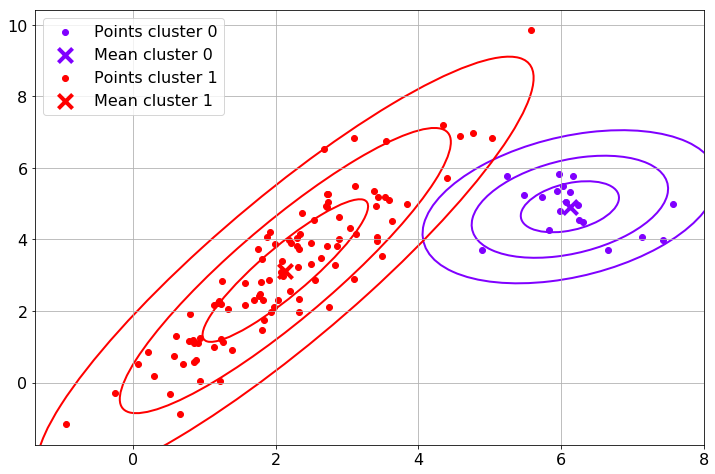

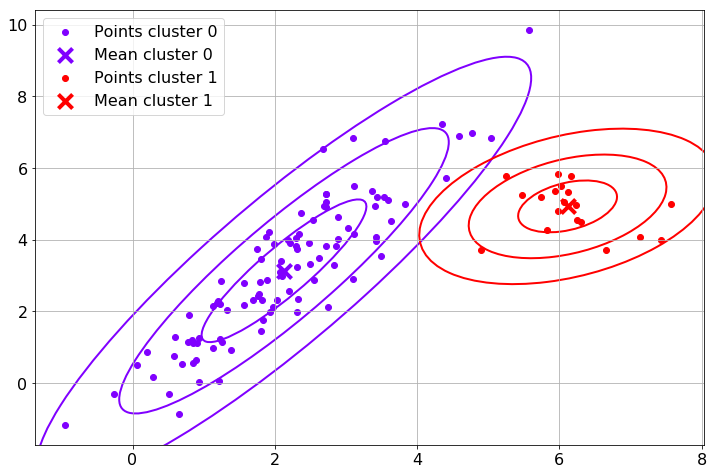

In [80]:
def run_and_plot_simple_em(data, means_init=None, k=2, num_iters=10): 
    """
    Runs the custom EM algorithm implementation on the input data and plots the results. 
    
    Args:
        data: Input data.
        means_init: Initial means of the gaussians.
        k: Number of mixture components.
        num_iters: Number of iterations.
    """
    # Apply the custom EM-algorithm implementation.
    # Store the cluster assignments in a variable called 'labels', the estimated means in a variable 'means',
    # the estimated weights in a variable 'weights' and the estimated covariances in a variable 'covariances'.
    em = SimpleEM(means_init=means_init, k=k, num_iters=num_iters)
    em.fit(data)
    labels = em.labels
    weights = em.pi
    means = np.array(em.means)
    covariances = em.sigmas
    
    # Print and plot results:
    print("Means:\n{}".format(means))
    print("Mixture weights:\n{}".format(weights))
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.grid()
    
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, k)]
    for i, color in enumerate(colors):
        cluster = data[labels==i]
        ax.scatter(cluster[:, 0], cluster[:, 1], color=color, label="Points cluster {}".format(i))
        plot_gaussian(ax, means[i], covariances[i], color=color, size=3)
        ax.scatter(means[i, 0], means[i, 1], color=color, marker="x", s=200, lw=4, label="Mean cluster {}".format(i))
        
    ax.legend()
    
# Run our implementation of the EM algorithm:
run_and_plot_simple_em(data, k=2, num_iters=50)


# Compare to the sklearn implementation of the EM algorithm:
run_and_plot_em(data)